## Package Governance - Custom Container Runtime Image

Building custom container runtime image gives the ultimate control in customizing your Watson Studio runtime configurations and libraries. Custom images can also be used in air-gapped environments with requirements which forbid exposing any operations to the internet.

To create a custom image, you need to download the image of the Juypter notebook runtime that you want to customize, build a new custom image by adding libraries to the image you downloaded, register the new image, and finally update the environment definition you created in your project to use the new custom image.


Prerequites:
  - must be CPD cluster admin to create and register custom image
  - some CLI tools are needed for this tutorial (`oc, jq, curl, docker`) as well as a Linux/Mac command line environment
  - prior knowledge of containers and building container images is highly recommended

### Building Custom Watson Studio Runtime Image

To build a custom runtime container image, there are a few high level steps 

1. Accessing the CPD cluster's image registry
2. Download the runtime configuration
3. Download the base Watson Studio image from your cluster
4. Create custom image with pre-installed packages from Dockerfile
5. Pust new image to CPD cluster's container image registry
6. Upload the changed configuration
7. Using the custom image


#### 1) Login to cluster and the get in-cluster image registry

```
# Login to your CPD cluster and switch to the installation namespace
oc login ...
oc project zen

export IMG_ROUTE=$(oc get route default-route -n openshift-image-registry -ojsonpath='{.spec.host}')
export CPD_ROUTE=$(oc get route zen-cpd -n zen -ojsonpath='{.spec.host}')

docker login $IMG_ROUTE -u me -p $(oc whoami -t)
```


#### 2) Get runtime configuration 

The example runtime we are targetting in this example is: "jupyter-py37-server.json". For a list of targets, check the documentation here https://www.ibm.com/docs/en/cloud-paks/cp-data/3.5.0?topic=image-downloading-runtime-configuration

```
export CONFIG_NAME='jupyter-py37-server.json'
export NEW_CONFIG='jupyter-py37-custom-server.json'

export myToken=`curl -k https://$CPD_ROUTE/v1/preauth/validateAuth -u admin:password | sed -n -e 's/^.*accessToken":"//p' | cut -d'"' -f1`

curl -X GET "https://$CPD_ROUTE/zen-data/v1/volumes/files/%2F_global_%2Fconfig%2F.runtime-definitions%2Fibm%2F$CONFIG_NAME" --header "Authorization: Bearer ${myToken}" -k -o $NEW_CONFIG
```


#### 3) Get image - login to cluster registry and pull base image to local machine

```
docker pull ${IMG_ROUTE}/zen/wslocal-runtime-py37omain:3.5.4017.2539-amd64
```

#### 4) Create custom image with your pre-installed packages

Customize the example docker file `ws-custom-dockerfile` included under the directory `./custom-image` in this example repo, and install packages with `conda` or `pip` as needed. If familiar with docker container images, other customizations can be done such as copying arbitrary files or packages into the image. 

```
NEW_IMAGE_NAME=cst-custom-wslocal-py37
NEW_IMAGE_NS=zen
NEW_IMAGE=${IMG_ROUTE}/${NEW_IMAGE_NS}/${NEW_IMAGE_NAME}
NEW_IMAGE_TAG=1.0
REG_INTERNAL=$(oc registry info --internal=true)
NEW_IMAGE_INTERNAL=$REG_INTERNAL/$NEW_IMAGE_NS/$NEW_IMAGE_NAME:$NEW_IMAGE_TAG

docker build -t $NEW_IMAGE:$NEW_IMAGE_TAG --build-arg base_image_tag=${IMG_ROUTE}/zen/wslocal-runtime-py37omain:3.5.4017.2539-amd64 -f ./custom-image/ws-custom-dockerfile .
 ```

#### 5) Push new image to cluster registry

Our custom image is now available locally. To double check, you can run `docker image list` to see if your custom image is built successfuly.

Then we push the custom image to the cluster registry.

```
docker push $NEW_IMAGE:$NEW_IMAGE_TAG
```

#### 6) Uploading changed configuration

Now we change our custom configuration to point to the new image in our cluster container registry.

```
# First update the "image" location in the jupyter-py37-custom-server.json file to point to your custom image.

jq ".image = \"$NEW_IMAGE_INTERNAL\"" $NEW_CONFIG > input.tmp && mv input.tmp $NEW_CONFIG


# Upload the configuration to the cluster using the token we've 
# saved from the previous command in section 2
curl -k -X PUT \
   "https://${CPD_ROUTE}/zen-data/v1/volumes/files/%2F_global_%2Fconfig%2F.runtime-definitions%2Fibm" \
   -H "Authorization: Bearer $myToken" \
   -H 'content-type: multipart/form-data' \
   -F upFile=@./$NEW_CONFIG
```

The returned messages is as follows:
```
{"_messageCode_":"Success","message":"Successfully uploaded file and created the directory structure"}
```



#### 7) Using the custom image

After the custom image was uploaded by the Cloud Pak for Data administrator, it is available in Watson Studio and can be selected when you create an environment definition. You need Admin or Editor permissions on the project to create an environment definition.

To create an environment definition that uses a custom image:

1. From the Environments tab in your project, click New environment definition.
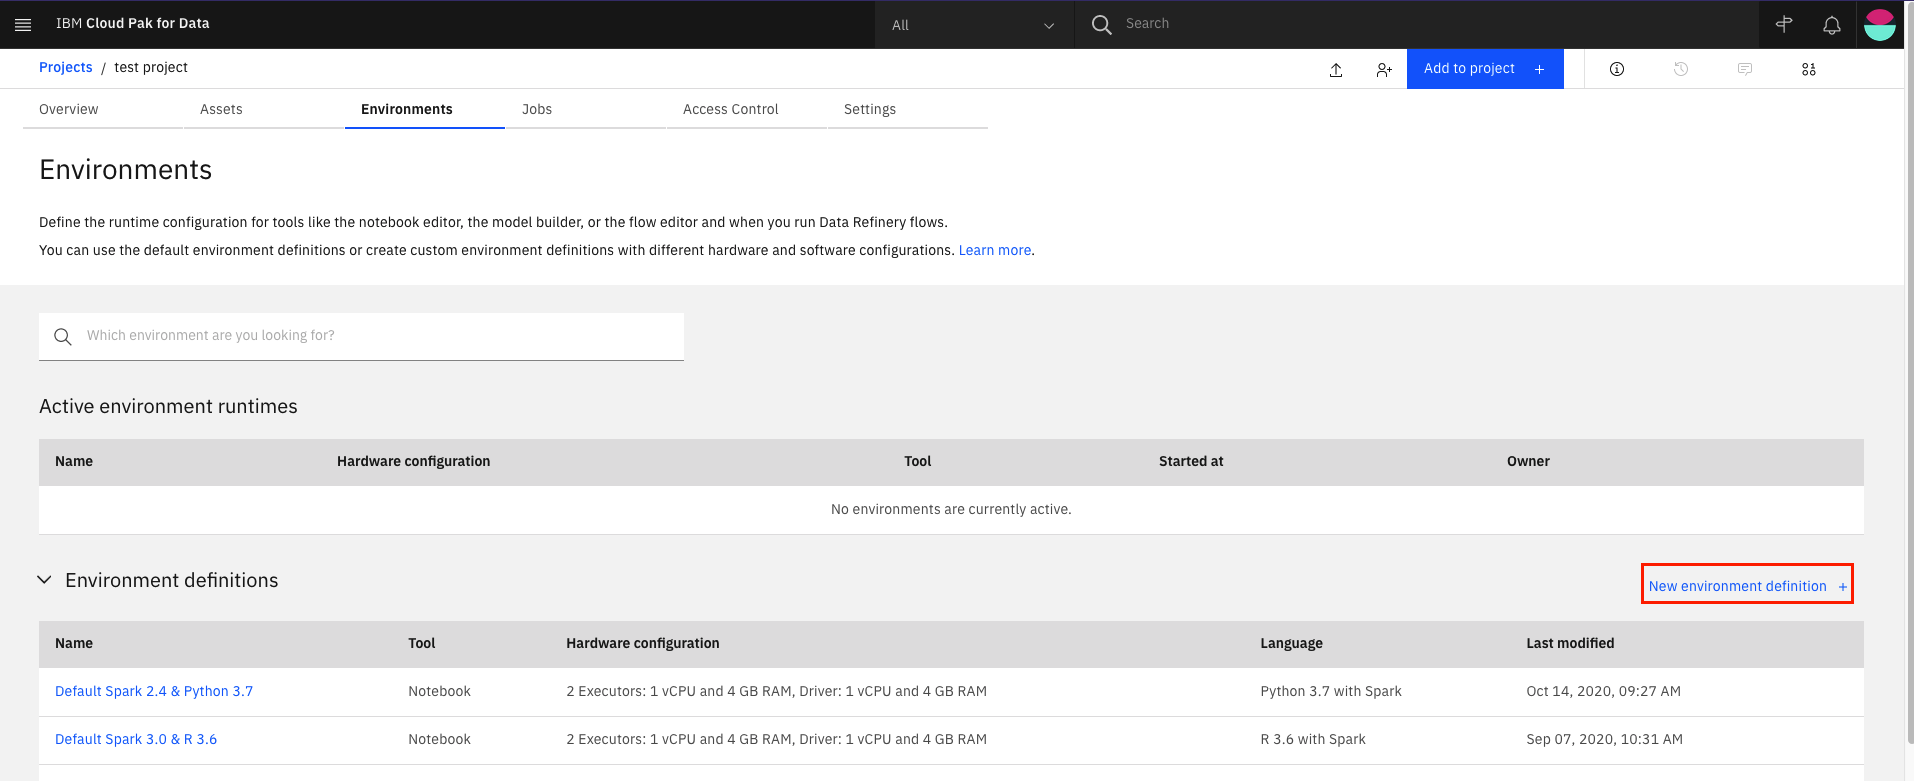
2. Enter a name and a description. Select the environment type Default.
3. Choose the hardware configuration size and select the custom definition we've just uploaded under the `Software Version` dropdown.
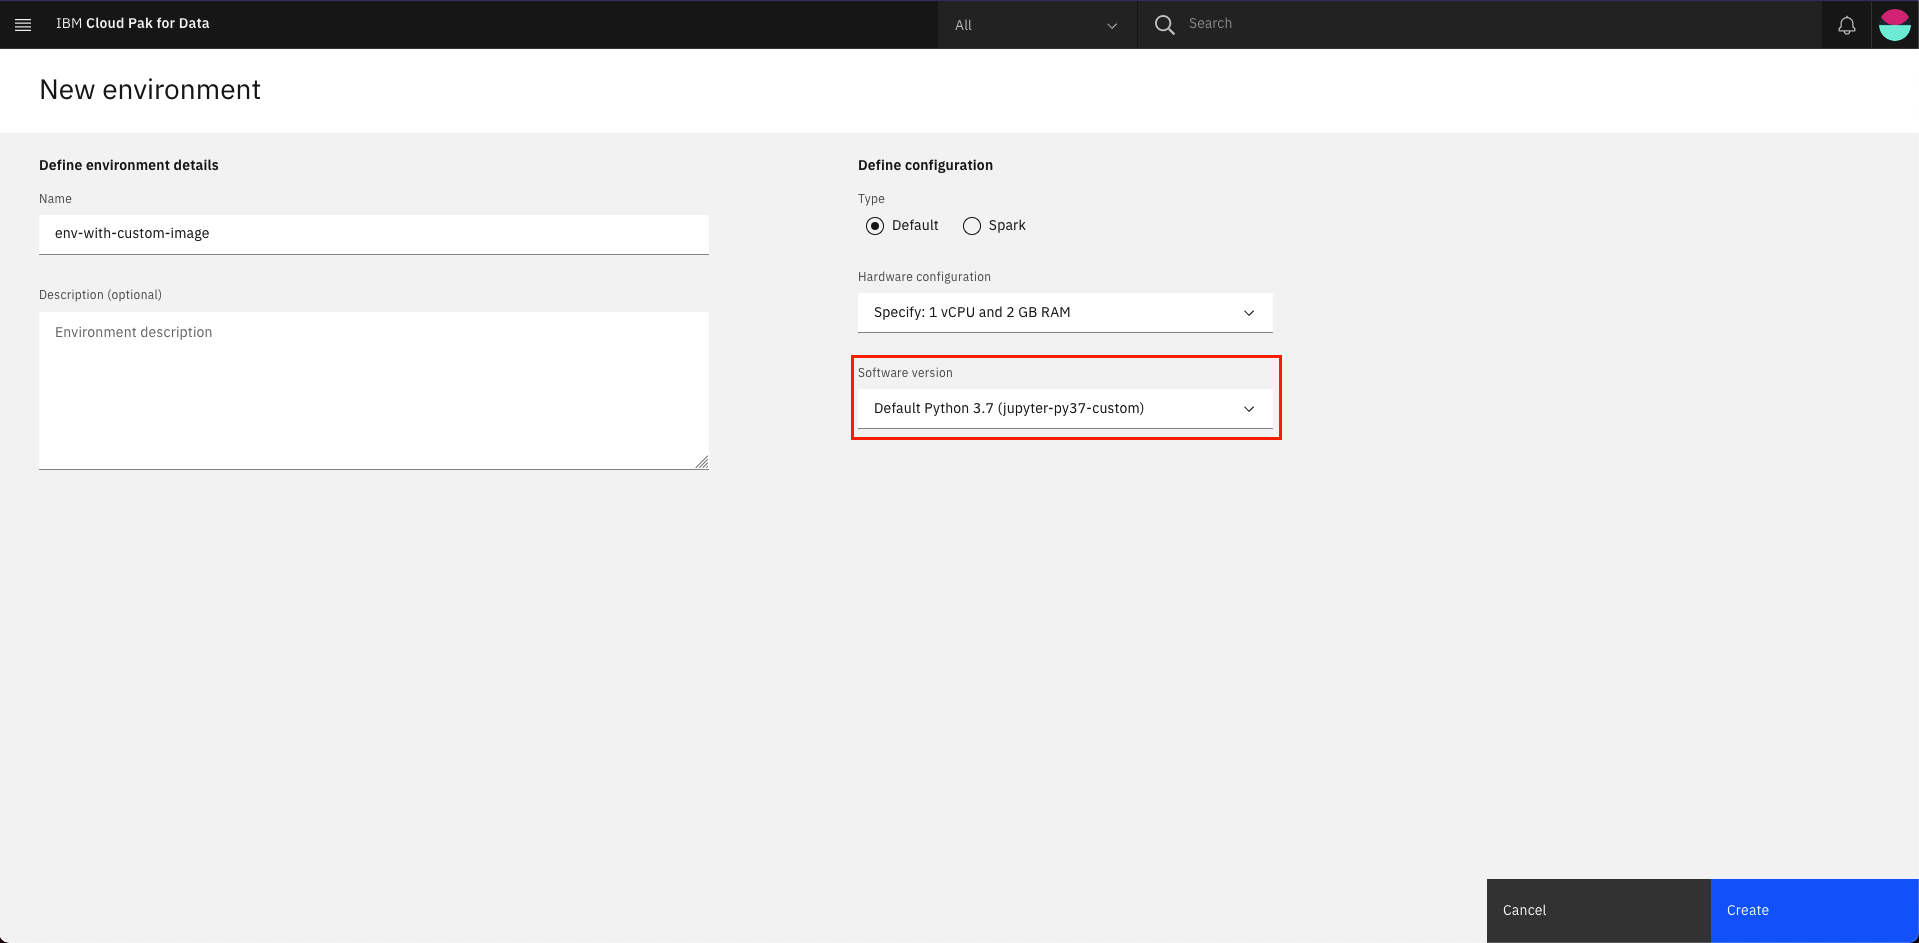

Now you can create a custom notebook with the custom environment we've just created
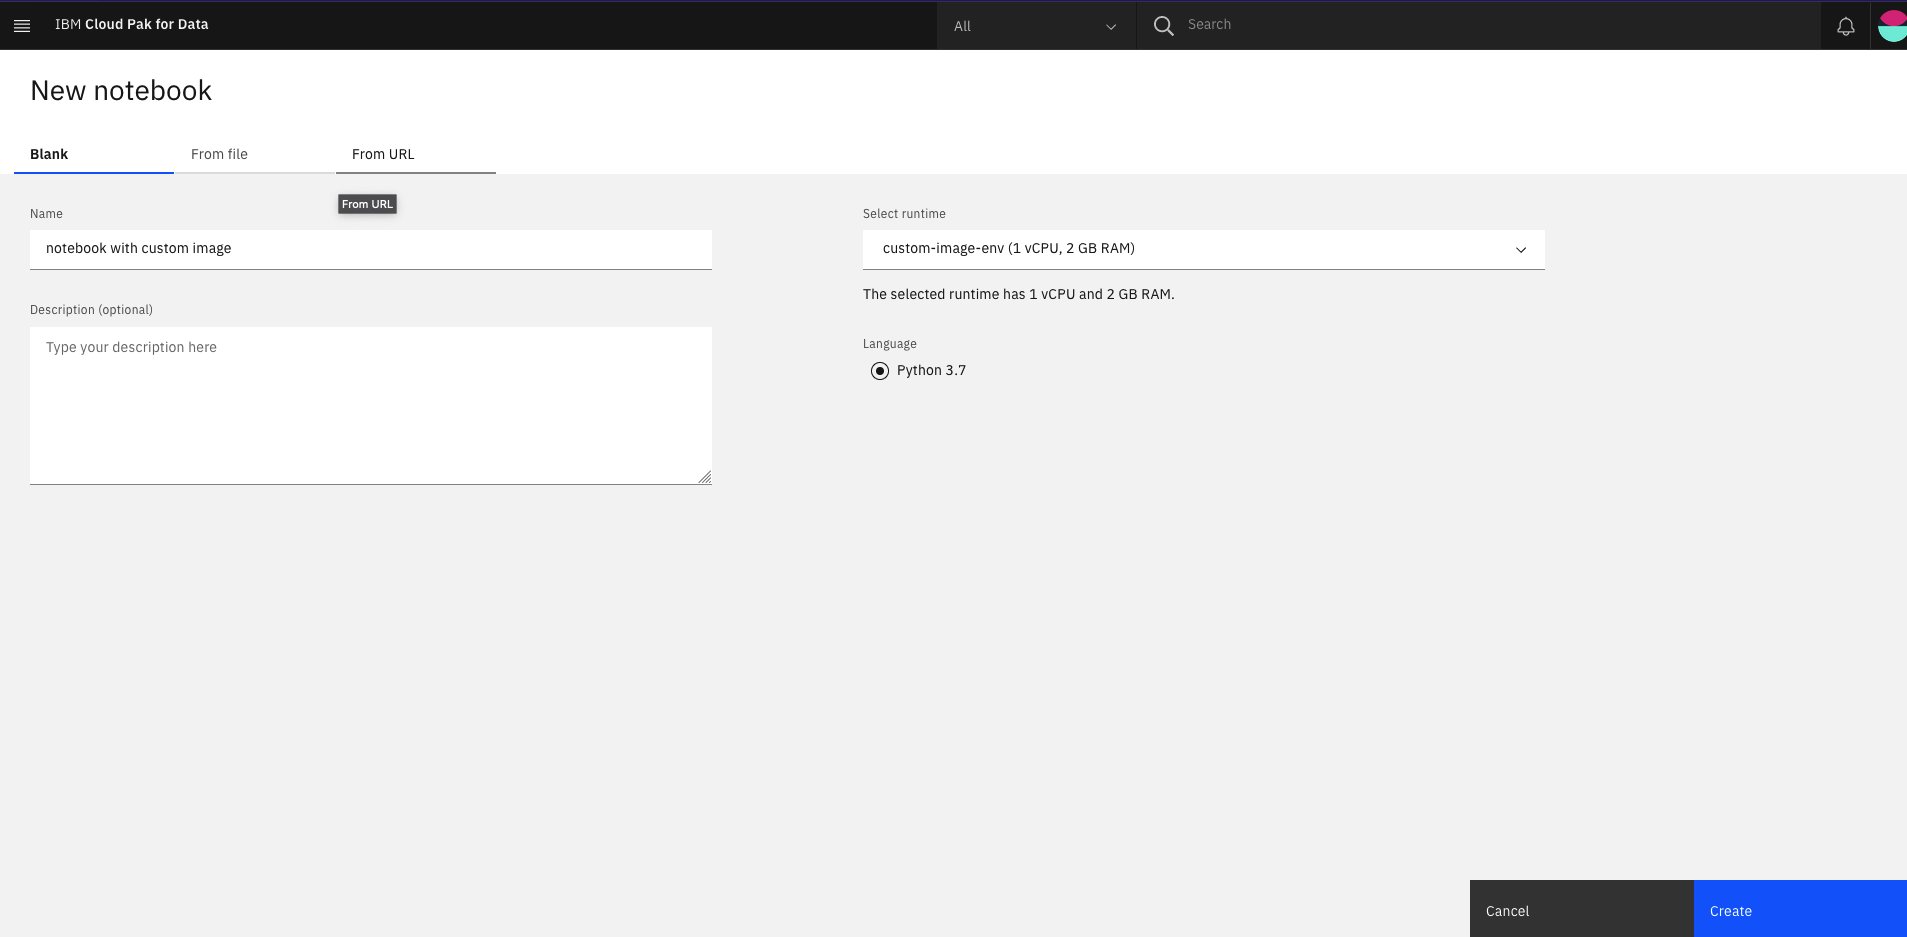


#### 8) Selecting custom image runtime in notebook
Notice we can import packages we have included in our custom image (installed during the image build time and customization of the Dockerfile) such as `aif360`, `seawater`, etc. without having to manually run pip install.

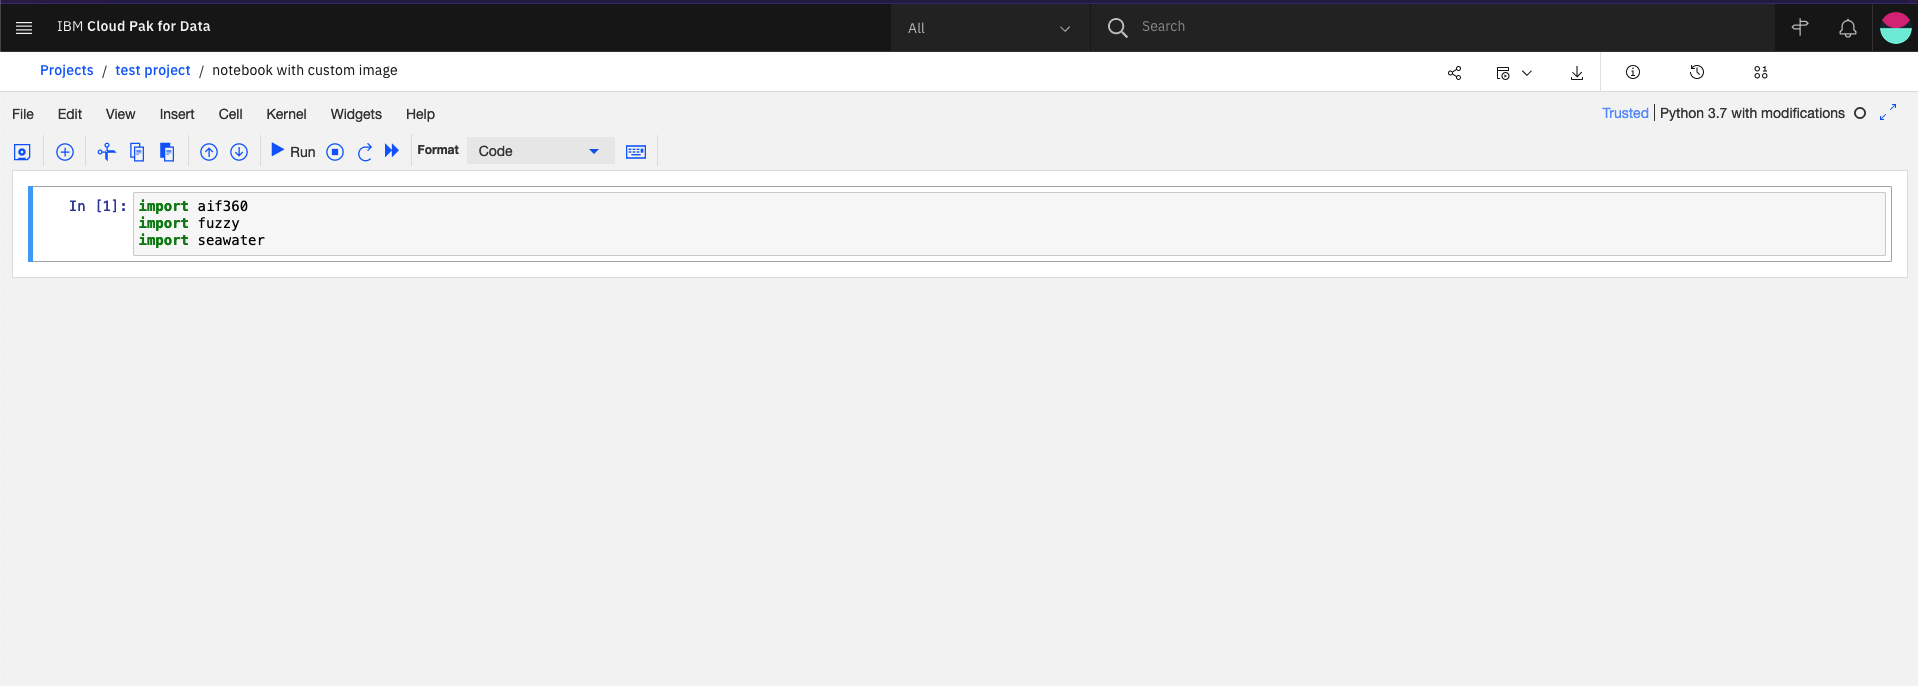

### References

https://www.ibm.com/docs/en/cloud-paks/cp-data/3.5.0?topic=images-preparing-build-image